# Análisis Espacial de Eventos de Inundación Pluviales en Medellín
Este cuaderno realiza un análisis de los 441 eventos de inundación (Flood causados por Rainfall). Calcula KDE, NND y clustering, y los representa sobre un mapa de fondo.
Se corrige la propagación de atributos entre CRS originales y WebMercator.

In [12]:
!pip install pointpats

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ---------------------- ----------------- 1.6/2.8 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 5.9 MB/s eta 0:00:00


## 1. Importación de librerías

In [45]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.geometry import Polygon
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
import matplotlib.ticker as ticker

## 2. Carga y preparación de datos

In [3]:
# Ruta al shapefile
shapefile_path = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\Inventario_inundaciones_lluvias_medellin.shp"

# Cargar datos
gdf = gpd.read_file(shapefile_path)

# Asignar CRS si no existe
print("CRS original:", gdf.crs)
if gdf.crs is None:
    gdf.set_crs(epsg=9377, inplace=True, allow_override=True)

# Crear versión WebMercator para basemap
gdf_web = gdf.to_crs(epsg=3857)


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83128\174252538.py:2: SyntaxWarning: invalid escape sequence '\S'
  shapefile_path = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\Inventario_inundaciones_lluvias_medellin.shp"


CRS original: EPSG:9377


## 3. Extracción de coordenadas métricas

In [4]:
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
coords[:5]


array([[4716193.77103549, 2249044.18543133],
       [4718274.5780644 , 2252102.08147138],
       [4716193.77103549, 2249044.18543133],
       [4716193.77103549, 2249044.18543133],
       [4716193.77103549, 2249044.18543133]])

## 4. Densidad de Kernel (KDE)

In [5]:
# 4. Estimación de Densidad de Kernel (KDE)
bandwidth = 500
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)

# Densidad original (m⁻²)
gdf['kde_density'] = np.exp(kde.score_samples(coords))
print("KDE stats - min, mean, max:", 
      gdf['kde_density'].min(), 
      gdf['kde_density'].mean(), 
      gdf['kde_density'].max())

# NUEVO: convertir a eventos por km²
gdf['kde_per_km2'] = gdf['kde_density'] * 1e6
print("=== KDE en eventos/km² ===")
print(gdf['kde_per_km2'].describe())

KDE stats - min, mean, max: 1.7294933854043516e-09 2.9110882295639007e-08 1.062115847474971e-07
=== KDE en eventos/km² ===
count    441.000000
mean       0.029111
std        0.033831
min        0.001729
25%        0.008531
50%        0.016244
75%        0.024216
max        0.106212
Name: kde_per_km2, dtype: float64


## 5. Distancia al Vecino Más Cercano (NND)

In [6]:
nn = NearestNeighbors(n_neighbors=2).fit(coords)
distances, _ = nn.kneighbors(coords)
gdf['nnd'] = distances[:, 1]
print("NND stats - min, mean, max:", gdf['nnd'].min(), gdf['nnd'].mean(), gdf['nnd'].max())
print("=== Estadísticas de NND ===")
print(gdf['nnd'].describe(), "\n")

NND stats - min, mean, max: 0.0 88.30897955611454 1080.0715911574657
=== Estadísticas de NND ===
count     441.000000
mean       88.308980
std       221.447926
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1080.071591
Name: nnd, dtype: float64 



## 6. Clustering con DBSCAN

In [41]:
db = DBSCAN(eps=800, min_samples=5).fit(coords)
gdf['cluster'] = db.labels_
print("Clusters:", len(set(gdf['cluster'])) - (1 if -1 in gdf['cluster'] else 0), "Noise points:", list(gdf['cluster']).count(-1))
print("=== Conteo por Cluster (DBSCAN) ===")
print(gdf['cluster'].value_counts(), "\n")

n_clusters = len([c for c in gdf['cluster'].unique() if c != -1])
n_noise    = (gdf['cluster'] == -1).sum()
print(f"Número de clusters: {n_clusters}")
print(f"Puntos ruido: {n_noise}")

Clusters: 12 Noise points: 38
=== Conteo por Cluster (DBSCAN) ===
cluster
 0     191
 1     116
-1      38
 6      32
 3      16
 2      10
 10     10
 4       7
 8       6
 5       5
 7       5
 9       5
Name: count, dtype: int64 

Número de clusters: 11
Puntos ruido: 38


## 7. Propagar atributos al CRS para mapas de fondo

In [42]:
# Propagar columnas calculadas a la versión WebMercator
for col in ['kde_density', 'nnd', 'cluster']:
    gdf_web[col] = gdf[col].values
# ——— PROPAGA LA NUEVA COLUMNA DE KDE EN KM² ———
gdf_web['kde_per_km2'] = gdf['kde_per_km2'].values

## 8. Visualización

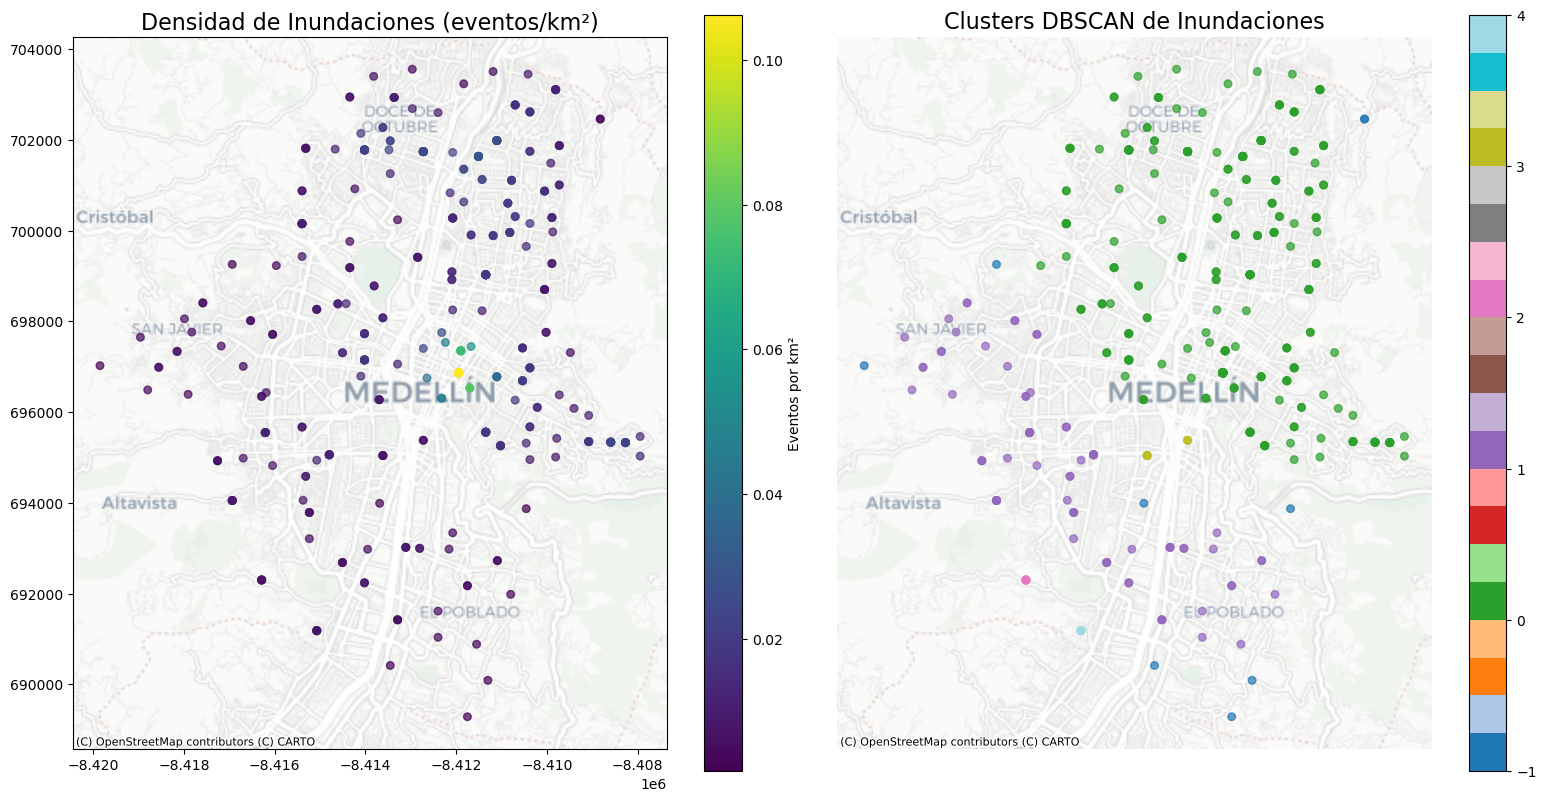

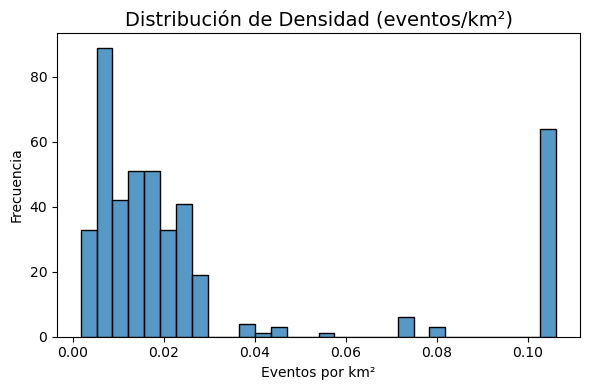

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

# KDE map
gdf_web.plot(
    column='kde_per_km2', ax=axes[0], legend=True,
    cmap='viridis', markersize=30, alpha=0.7,
    legend_kwds={'label': "Eventos por km²"}
)
ctx.add_basemap(axes[0], source=ctx.providers.CartoDB.Positron, zoom=12)
axes[0].set_title('Densidad de Inundaciones (eventos/km²)', fontsize=16)

# Cluster map
gdf_web.plot(column='cluster', ax=axes[1], legend=True, cmap='tab20', markersize=30, alpha=0.7)
ctx.add_basemap(
    axes[1],
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)
axes[1].set_title('Clusters DBSCAN de Inundaciones', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Histograma de KDE en eventos/km²
plt.figure(figsize=(6,4))
sns.histplot(gdf['kde_per_km2'], bins=30, edgecolor='black')
plt.title('Distribución de Densidad (eventos/km²)', fontsize=14)
plt.xlabel('Eventos por km²')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


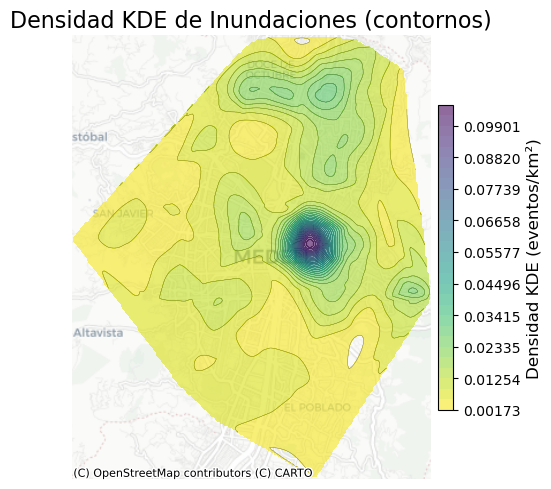

In [46]:
# ——— KDE CON CONTORNOS ———
# 1) Extraer X, Y y densidad real en eventos/km²
x = gdf_web.geometry.x.values
y = gdf_web.geometry.y.values
vals = gdf_web['kde_per_km2'].values

# 2) Crear malla regular
xmin, ymin, xmax, ymax = gdf_web.total_bounds
nx, ny = 200, 200
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(xi, yi)

# 3) Interpolar KDE sobre la malla
zi = griddata((x, y), vals, (xx, yy), method='cubic')

# 4) Niveles equiespaciados según tu rango de datos
levels = np.linspace(vals.min(), vals.max(), 30)

# 5) Dibujar contourf + isolíneas
fig, ax = plt.subplots(figsize=(5, 5))
cf = ax.contourf(
    xx, yy, zi,
    levels=levels,
    cmap='viridis_r',
    alpha=0.6
)
ax.contour(
    xx, yy, zi,
    levels=levels,
    colors='k',
    linewidths=0.3,
    alpha=0.5
)

# 6) Colorbar en el mismo fig
cbar = fig.colorbar(cf, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('Densidad KDE (eventos/km²)', fontsize=12)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
cbar.ax.yaxis.get_offset_text().set_visible(False)

# 7) Basemap y estilo final
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)
ax.set_title('Densidad KDE de Inundaciones (contornos)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83128\985571722.py:10: SyntaxWarning: invalid escape sequence '\S'
  city = gpd.read_file("D:\Semestre 2025-1\Analisis Geoespacial\SHP\Medellin.shp")                       # ajusta ruta si es necesario
C:\Users\Usuario\AppData\Local\Temp\ipykernel_83128\985571722.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_shape = city_web.unary_union                          # geometría combinada


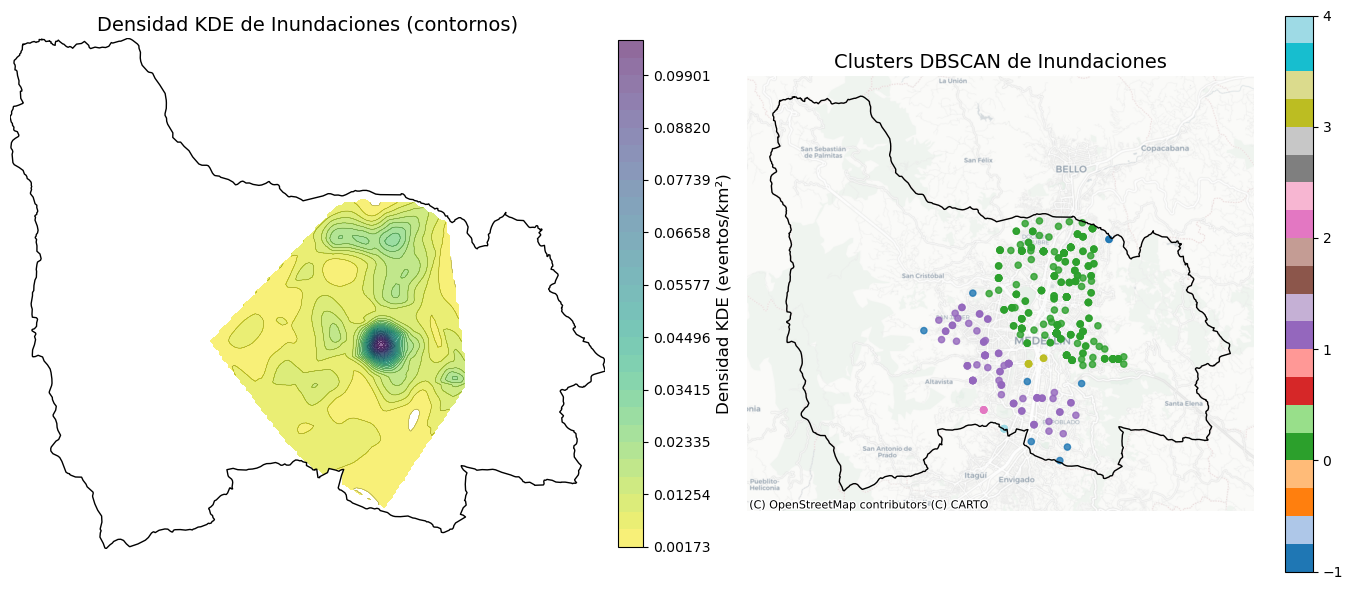

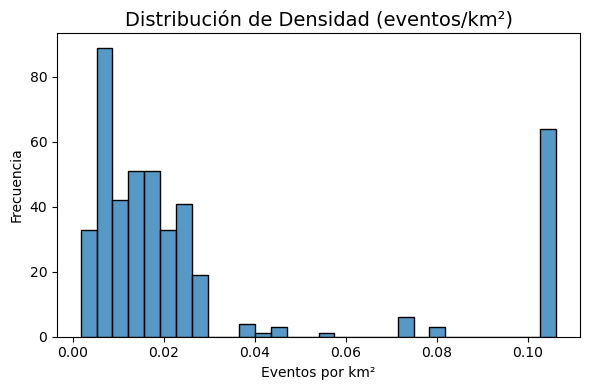

In [28]:
# ——— KDE ENMASCARADO Y CLUSTERS JUNTOS ———
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
from shapely.geometry import Point
import geopandas as gpd

# --- 0) Cargar y reproyectar el polígono de Medellín ---
city = gpd.read_file("D:\Semestre 2025-1\Analisis Geoespacial\SHP\Medellin.shp")                       # ajusta ruta si es necesario
city_web = city.to_crs(epsg=3857)
city_shape = city_web.unary_union                          # geometría combinada

# --- 1) Clip de tus puntos de inundación al área de Medellín ---
gdf_clip = gdf_web.clip(city_web)

# --- 2) Extraer x, y y densidad solo dentro del polígono ---
x = gdf_clip.geometry.x.values
y = gdf_clip.geometry.y.values
vals = gdf_clip['kde_per_km2'].values

# --- 3) Crear malla regular dentro de los bounds de Medellín ---
xmin, ymin, xmax, ymax = city_web.total_bounds
nx, ny = 200, 200
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(xi, yi)

# --- 4) Interpolar la densidad KDE sobre la malla ---
zi = griddata((x, y), vals, (xx, yy), method='cubic')

# --- 5) Enmascarar todo lo que quede fuera del polígono ---
# creamos un vector de puntos de la malla
pts = [Point(px, py) for px, py in zip(xx.ravel(), yy.ravel())]
mask = np.array([city_shape.contains(pt) for pt in pts]).reshape(xx.shape)
zi_masked = np.where(mask, zi, np.nan)

# --- 6) Preparar niveles de contorno ---
levels = np.linspace(vals.min(), vals.max(), 30)

# --- 7) Gráfico lado a lado: KDE y clusters ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- 7a) KDE con contourf + isolíneas ---
cf = axes[0].contourf(
    xx, yy, zi_masked,
    levels=levels,
    cmap='viridis_r',
    alpha=0.6
)
axes[0].contour(
    xx, yy, zi_masked,
    levels=levels,
    colors='k', linewidths=0.3, alpha=0.5
)
# añadir frontera real
city_web.boundary.plot(ax=axes[0], edgecolor='black', linewidth=1)

# colorbar
cbar = fig.colorbar(cf, ax=axes[0], fraction=0.04, pad=0.02)
cbar.set_label('Densidad KDE (eventos/km²)', fontsize=12)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
cbar.ax.yaxis.get_offset_text().set_visible(False)

axes[0].set_title('Densidad KDE de Inundaciones (contornos)', fontsize=14)
axes[0].axis('off')

# --- 7b) Mapa de clusters DBSCAN (recortado) ---
gdf_clip.plot(
    column='cluster',
    ax=axes[1],
    cmap='tab20',
    markersize=20,
    alpha=0.8,
    legend=True
)
# superponer frontera
city_web.boundary.plot(ax=axes[1], edgecolor='black', linewidth=1)

# basemap
ctx.add_basemap(axes[1], source=ctx.providers.CartoDB.Positron, zoom=12)

axes[1].set_title('Clusters DBSCAN de Inundaciones', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# --- 8) Histograma KDE ---
plt.figure(figsize=(6,4))
sns.histplot(gdf_clip['kde_per_km2'], bins=30, edgecolor='black')
plt.title('Distribución de Densidad (eventos/km²)', fontsize=14)
plt.xlabel('Eventos por km²')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_83128\3916284207.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_cats)


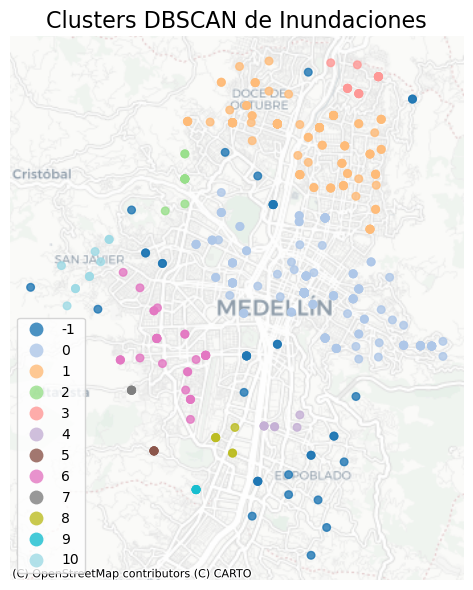

In [44]:
# 1) Calcula cuántas categorías únicas hay
cats = sorted(gdf_web['cluster'].unique())   # [-1, 0, 1, 2, 3, 4]
n_cats = len(cats)                           # 6

# 2) Carga un colormap discreto con justo n_cats colores
from matplotlib import cm
cmap = cm.get_cmap('tab20', n_cats)

# 3) Dibuja como categórico
fig, ax = plt.subplots(figsize=(6,6))
gdf_web.plot(
    column='cluster',
    categorical=True,
    cmap=cmap,
    legend=True,
    ax=ax,
    markersize=30,
    alpha=0.8
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)
ax.set_title('Clusters DBSCAN de Inundaciones', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## 9. Guardar resultados

In [ ]:
output_path = "inventario_inundaciones_features_updated.shp"
gdf.to_file(output_path)
print(f"Guardado: {output_path}")


## 10. Análisis de Quadrats
Dividimos el área de estudio en una malla de 10×10 celdas y contamos cuántos eventos de inundación caen en cada celda.
El conteo resultante (`quadrat_count`) se añade como una nueva columna al GeoDataFrame y se representa en un mapa coroplético.

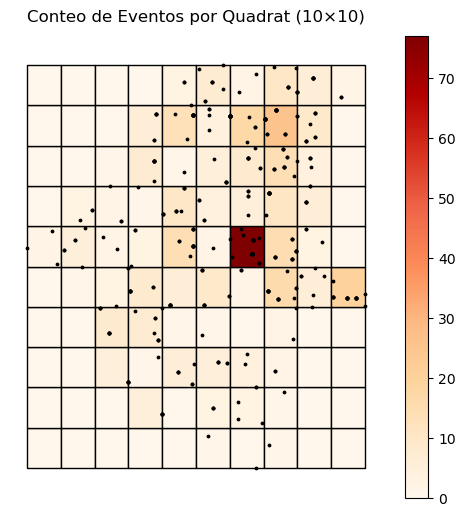

— Estadísticas de quadrat_count —
count    441.000000
mean      21.988662
std       26.062902
min        0.000000
25%        6.000000
50%       11.000000
75%       20.000000
max       77.000000
Name: quadrat_count, dtype: float64


In [11]:
from shapely.geometry import Polygon

# Definir cuadrícula de quadrats (10x10)
xmin, ymin, xmax, ymax = gdf.total_bounds
n_cols, n_rows = 10, 10
dx = (xmax - xmin) / n_cols
dy = (ymax - ymin) / n_rows

# Crear polígonos
quads = []
for i in range(n_cols):
    for j in range(n_rows):
        quads.append(Polygon([
            (xmin + i*dx, ymin + j*dy),
            (xmin + (i+1)*dx, ymin + j*dy),
            (xmin + (i+1)*dx, ymin + (j+1)*dy),
            (xmin + i*dx, ymin + (j+1)*dy)
        ]))
quad_polys = gpd.GeoDataFrame({'geometry': quads}, crs=gdf.crs)

# Contar eventos por quadrat
join = gpd.sjoin(gdf[['geometry']], quad_polys, how='left', predicate='within')
counts = join.groupby('index_right').size().reindex(range(len(quads)), fill_value=0)
quad_polys['count'] = counts.values

# Añadir feature al GeoDataFrame original
gdf['quadrat_count'] = join['index_right'].map(counts).fillna(0).astype(int).values

# Visualizar conteos
fig, ax = plt.subplots(figsize=(6,6))
quad_polys.plot(column='count', cmap='OrRd', edgecolor='black', legend=True, ax=ax)
gdf.plot(ax=ax, color='black', markersize=3)
ax.set_title('Conteo de Eventos por Quadrat (10×10)')
ax.axis('off')
plt.show()
print("— Estadísticas de quadrat_count —")
print(gdf['quadrat_count'].describe())

## 11. Función K de Ripley
Calculamos la función K(d) para evaluar la escala de agrupamiento de los eventos
y comparamos con un patrón aleatorio (CSR) para obtener una banda de confianza del 95%.

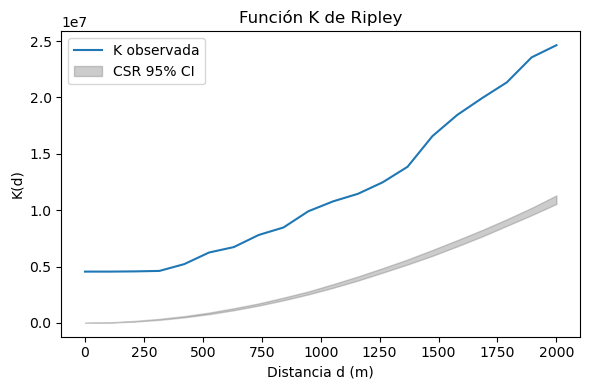

d = 0 m  →  K_obs = 4.55e+06
d = 105 m  →  K_obs = 4.55e+06
d = 211 m  →  K_obs = 4.57e+06
d = 316 m  →  K_obs = 4.61e+06
d = 421 m  →  K_obs = 5.21e+06
d = 526 m  →  K_obs = 6.24e+06
d = 632 m  →  K_obs = 6.72e+06
d = 737 m  →  K_obs = 7.80e+06
d = 842 m  →  K_obs = 8.46e+06
d = 947 m  →  K_obs = 9.90e+06

Primera distancia con clustering significativo (d>0): 105 m


In [12]:
# Preparar patrón puntual
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
n = coords.shape[0]
xmin, ymin, xmax, ymax = gdf.total_bounds
area = (xmax - xmin) * (ymax - ymin)

# Definir distancias
max_dist = 2000
n_d = 20
ds = np.linspace(0, max_dist, n_d)

# Calcular K(d) observado
dist_mat = distance_matrix(coords, coords)
K_obs = []
for d in ds:
    count = np.sum((dist_mat <= d)) - n  # excluir distancia a sí mismo
    K_obs.append(area / (n * (n - 1)) * count)

# Simulaciones CSR
sim_ks = []
for _ in range(99):
    xs = np.random.uniform(xmin, xmax, n)
    ys = np.random.uniform(ymin, ymax, n)
    sim_coords = np.vstack([xs, ys]).T
    sim_dist = distance_matrix(sim_coords, sim_coords)
    k_vals = []
    for d in ds:
        cnt = np.sum((sim_dist <= d)) - n
        k_vals.append(area / (n * (n - 1)) * cnt)
    sim_ks.append(k_vals)
sim_ks = np.array(sim_ks)
k_low = np.percentile(sim_ks, 2.5, axis=0)
k_high = np.percentile(sim_ks, 97.5, axis=0)

# Graficar K(d)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ds, K_obs, label='K observada')
ax.fill_between(ds, k_low, k_high, color='gray', alpha=0.4, label='CSR 95% CI')
ax.set_xlabel('Distancia d (m)')
ax.set_ylabel('K(d)')
ax.set_title("Función K de Ripley")
ax.legend()
plt.tight_layout()
plt.show()
# Mostrar los primeros valores de K(d)
for d, k in zip(ds[:10], K_obs[:10]):
    print(f"d = {d:.0f} m  →  K_obs = {k:.2e}")
    
# Encontrar la distancia crítica donde K_obs sale de la banda CSR
# Excluir d=0
mask = (K_obs[1:] > k_high[1:])
if mask.any():
    # Encontramos el primer índice verdadero en mask y sumamos +1 para re-ajustar al índice original
    idx = mask.argmax() + 1
    d_crit = ds[idx]
    print(f"\nPrimera distancia con clustering significativo (d>0): {d_crit:.0f} m")
else:
    print("\nNo hay agregación significativa para d>0 en [0, 2000] m")